<a href="https://www.kaggle.com/code/sefaberkacar/recommendation-system-on-goodbooks?scriptVersionId=165789396" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)


df_booktags = pd.read_csv("/kaggle/input/goodbooks-10k/book_tags.csv")
df_books = pd.read_csv("/kaggle/input/goodbooks-10k/books.csv")
df_rating = pd.read_csv("/kaggle/input/goodbooks-10k/ratings.csv")
df_tags = pd.read_csv("/kaggle/input/goodbooks-10k/tags.csv")
df_toread = pd.read_csv("/kaggle/input/goodbooks-10k/to_read.csv")

# Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


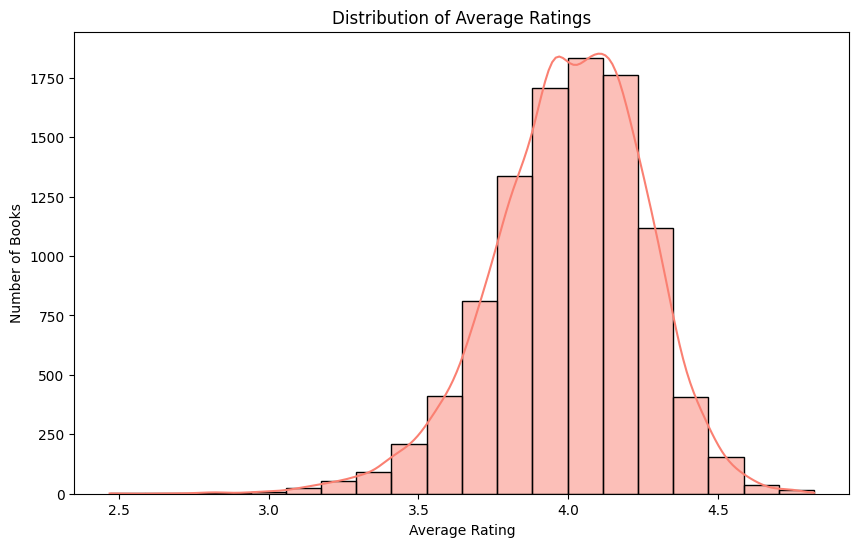

In [2]:
# Distribution of average ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_books['average_rating'].dropna(), bins=20, kde=True, color='salmon')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.show()

The average ratings are distributed normally, with most books in the dataset receiving ratings between 3.5 and 4.5. This indicates that the books included are generally well-regarded by readers, or that there is a tendency for ratings to cluster around this range.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


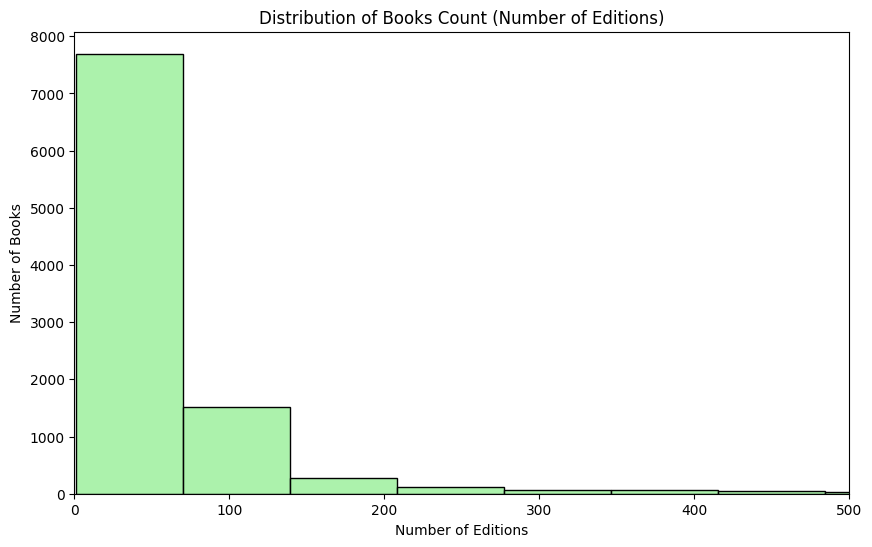

In [3]:
# Distribution of books count (number of editions)
plt.figure(figsize=(10, 6))
sns.histplot(df_books['books_count'], bins=50, kde=False, color='lightgreen')
plt.title('Distribution of Books Count (Number of Editions)')
plt.xlabel('Number of Editions')
plt.ylabel('Number of Books')
plt.xlim(0, 500)
plt.show()

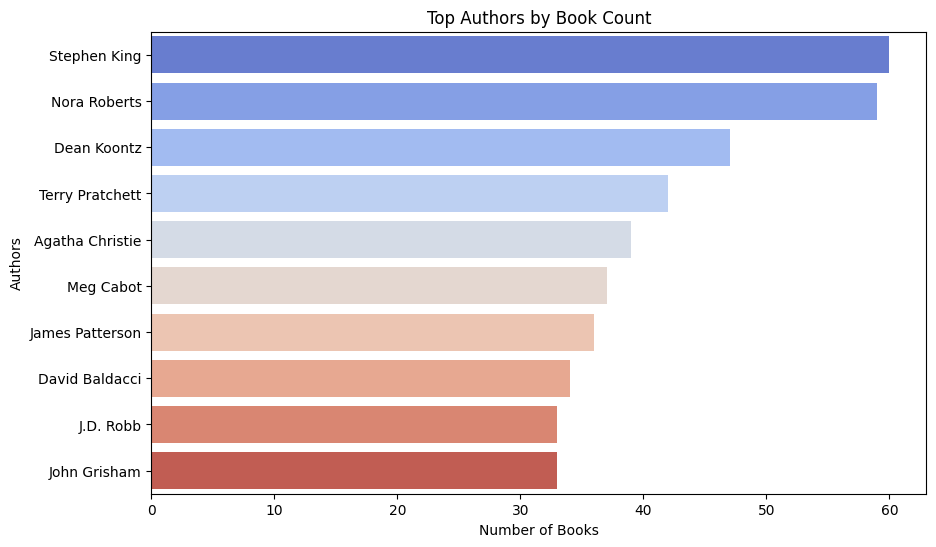

In [4]:
# Top authors by book count
top_authors = df_books['authors'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index.values, palette='coolwarm')
plt.title('Top Authors by Book Count')
plt.xlabel('Number of Books')
plt.ylabel('Authors')
plt.show()

The bar plot shows the authors with the highest number of books listed in the dataset. This indicates which authors are most frequently represented, suggesting their popularity or prolific nature in terms of published works.

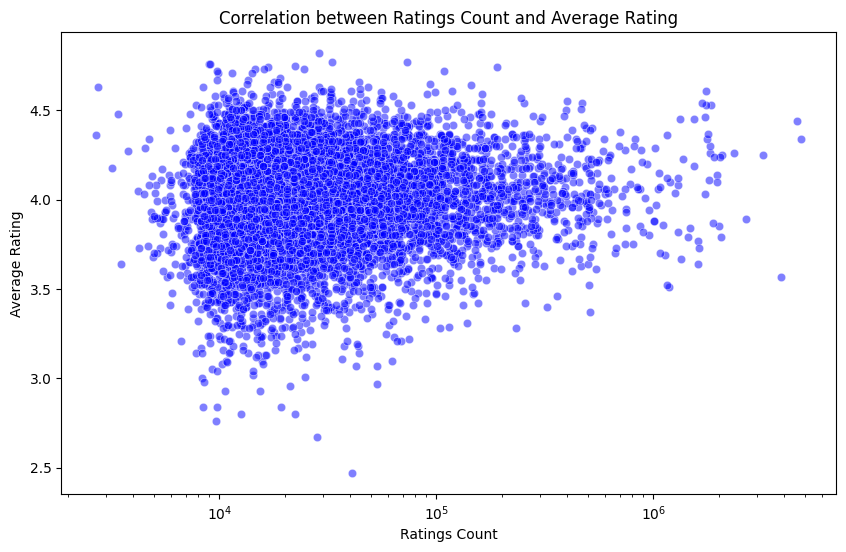

In [5]:
# Correlation between ratings count and average rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_books, x='ratings_count', y='average_rating', alpha=0.5, color='blue')
plt.title('Correlation between Ratings Count and Average Rating')
plt.xlabel('Ratings Count')
plt.ylabel('Average Rating')
plt.xscale('log')  # Using logarithmic scale for better visualization
plt.show()

The scatter plot shows the correlation between the number of ratings a book receives and its average rating. The x-axis (ratings count) is on a logarithmic scale for better visualization. Despite the wide range of ratings counts, the average ratings cluster around 3.5 to 4.5, as previously noted. There is not necessarily a strong correlation between a book's popularity, as measured by the number of ratings, and its average rating. Books with a high number of ratings can have a wide range of average ratings. However, there is a slight concentration of books with higher ratings counts also having moderately high average ratings.

The function unicodedata.normalize('NFKC', x) converts full-width characters to their standard (half-width) form. This enables the regular expression to remove any special characters and convert the text to lowercase.

In [6]:
import unicodedata

# Remove special characters and convert to lowercase
df_tags['tag_name'] = df_tags['tag_name'].apply(lambda x: unicodedata.normalize('NFKC', x))
df_tags['tag_name'] = df_tags['tag_name'].str.replace('[^\w\s]', '', regex=True).str.lower()
df_tags['tag_name'] = df_tags['tag_name'].str.strip()


Create a new DataFrame containing the top tag_ids for each goodreads_book_id based on the count column

In [7]:
top_tags = df_booktags.groupby('goodreads_book_id').apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)
top_tags = top_tags.merge(df_tags, how='left', on='tag_id')

/tmp/ipykernel_18/3093771019.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_tags = df_booktags.groupby('goodreads_book_id').apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)


In [8]:
books_tags_years = df_books.merge(top_tags, left_on='book_id', right_on='goodreads_book_id')

selected_genres = ['fantasy', 'romance', 'sciencefiction', 'nonfiction', 'mystery', 'historical', 'youngadult']

books_tags_years_filtered = books_tags_years[books_tags_years['tag_name'].isin(selected_genres)]

tags_by_year = books_tags_years_filtered.groupby(['original_publication_year', 'tag_name']).size().unstack(fill_value=0)

tags_by_year.tail()

tag_name,fantasy,mystery,nonfiction,romance,sciencefiction,youngadult
original_publication_year,,,,,,
2012.0,4,2,2,4,1,6
2013.0,3,5,1,11,2,1
2014.0,5,4,2,5,0,4
2015.0,5,1,0,1,0,2
2016.0,2,2,0,0,1,0


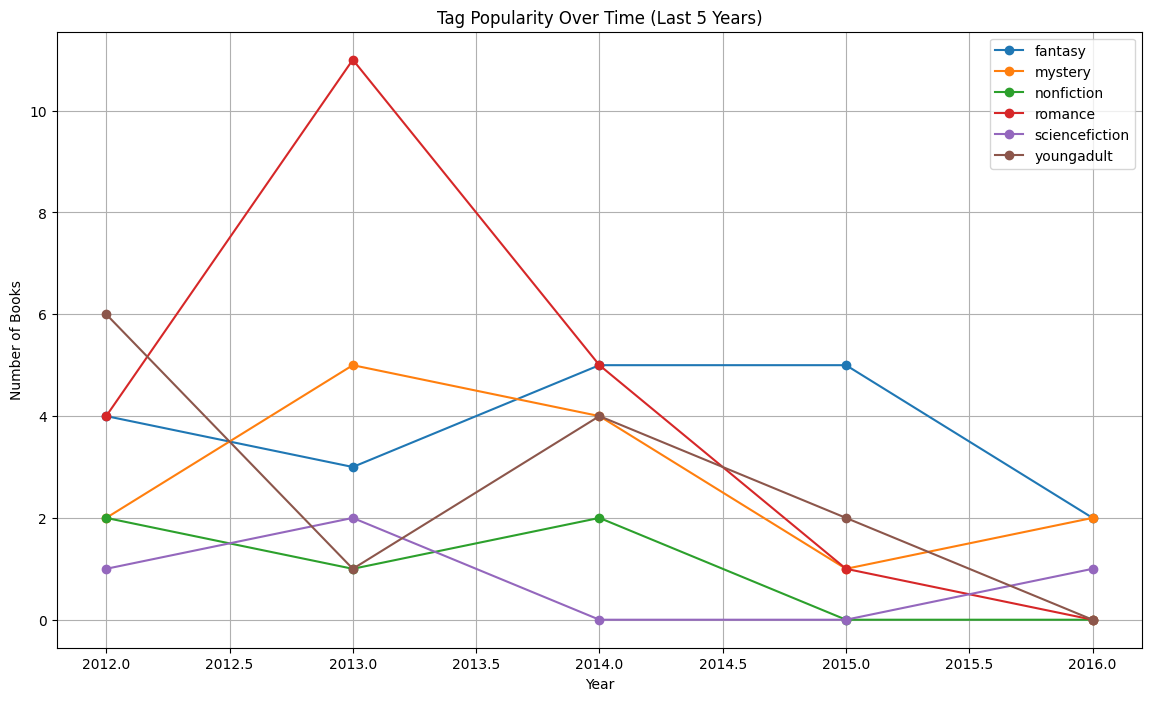

In [9]:
selected_years = tags_by_year.tail(5)  # Focus on the last 5 years available in the dataset

plt.figure(figsize=(14, 8))
for genre in selected_years.columns:
    plt.plot(selected_years.index, selected_years[genre], label=genre, marker='o')

plt.title('Tag Popularity Over Time (Last 5 Years)')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.legend()
plt.grid(True)
plt.show()


The line graph shows the popularity of selected genre/theme tags over the past five years, indicating the number of books associated with each genre per year. This visualization enables us to observe fluctuations and trends in genre popularity, such as the consistent presence of genres like fantasy and the varying interest in others like science fiction and romance over time.

In [10]:
popular_genres = top_tags[top_tags['tag_name'].str.contains('fiction|fantasy|romance|thriller|historical|youngadult|classics|nonfiction', regex=True)]

books_with_genres = df_books.merge(popular_genres, left_on='book_id', right_on='goodreads_book_id')

average_ratings_by_genre = books_with_genres.groupby('tag_name')['average_rating'].mean().sort_values(ascending=False)

to_read_with_genres = df_toread.merge(books_with_genres[['book_id', 'tag_name']], on='book_id')
to_read_counts_by_genre = to_read_with_genres['tag_name'].value_counts().sort_values(ascending=False)

average_ratings_by_genre = pd.DataFrame(average_ratings_by_genre)

average_ratings_by_genre

,average_rating
tag_name,
christianfiction,4.415000
realisticfiction,4.340000
paranormalromance,4.286364
urbanfantasy,4.208125
historicalromance,4.130769
fantasy,4.086777
romance,4.056216
thriller,4.046000
sciencefiction,3.985000


<Figure size 1000x600 with 0 Axes>

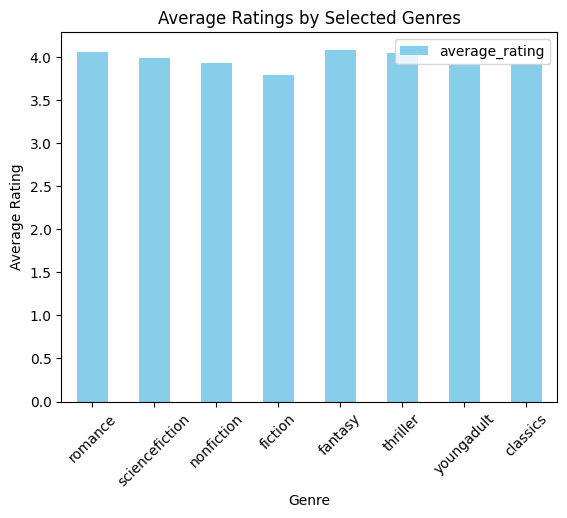

In [11]:
# Selecting a subset of genres for the graph to simplify
subset_genres = ['romance', 'sciencefiction', 'nonfiction',"fiction","fantasy","thriller", "youngadult", "classics"]
subset_average_ratings = average_ratings_by_genre.loc[subset_genres]

plt.figure(figsize=(10, 6))
subset_average_ratings.plot(kind='bar', color='skyblue')
plt.title('Average Ratings by Selected Genres')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

The bar graph displays average ratings for selected genres. This visualization facilitates comparison of user engagement across genres such as fantasy, romance, science fiction, and nonfiction, with each genre's average rating depicted.

In [12]:
# Author Analysis: Highest Average Ratings and Most Books Published

books_expanded_authors = df_books.assign(authors=df_books['authors'].str.split(',')).explode('authors')
books_expanded_authors['authors'] = books_expanded_authors['authors'].str.strip()

author_stats = books_expanded_authors.groupby('authors').agg(
    average_rating=pd.NamedAgg(column='average_rating', aggfunc='mean'),
    books_published=pd.NamedAgg(column='book_id', aggfunc='count')
).reset_index()

authors_high_ratings = author_stats[author_stats['books_published'] >= 5].sort_values(by='average_rating', ascending=False).head(10)

authors_most_books = author_stats.sort_values(by='books_published', ascending=False).head(10)

authors_high_ratings = pd.DataFrame(authors_high_ratings)
authors_most_books = pd.DataFrame(authors_most_books)
authors_high_ratings

,authors,average_rating,books_published
626,Bill Watterson,4.703077,13
3729,Mary GrandPré,4.545556,9
4936,Sarah J. Maas,4.453077,13
3556,Malcolm Jones III,4.442000,5
1849,Gary Smalley,4.430000,5
1735,Fiona Staples,4.418571,7
5461,Todd Klein,4.416000,10
2869,Jorge Luis Borges,4.390000,5
5,A.A. Milne,4.386667,6
631,Bisco Hatori,4.381667,6


In [13]:
authors_most_books

,authors,average_rating,books_published
2379,James Patterson,3.931735,98
5157,Stephen King,3.984227,97
4164,Nora Roberts,4.087692,65
1304,Dean Koontz,3.852969,64
5359,Terry Pratchett,4.134800,50
62,Agatha Christie,3.889302,43
2267,J.D. Robb,4.310976,41
4096,Neil Gaiman,4.198780,41
3812,Meg Cabot,3.798947,38
2426,Janet Evanovich,3.937027,37


# İtem Based

Item-based recommendation is a technique that suggests items to users based on the similarity between items, rather than the user's past behaviour. Similarity is calculated based on user ratings or interactions with items, and items similar to those the user has liked in the past are recommended. This approach is often more stable and scalable than user-based systems. Item similarities change less frequently and can be reused for multiple users.

In [14]:
df = df_books.merge(df_rating, how="left", on="book_id")
df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,user_id,rating
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,NaN,NaN
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,314.0,3.0
2,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,588.0,1.0
3,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,2077.0,2.0
4,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,2487.0,3.0


In [15]:
df.drop("language_code", axis=1,inplace=True)
df.drop("isbn", axis=1,inplace=True)
df.drop("isbn13", axis=1,inplace=True)
df.drop("original_title", axis=1,inplace=True)
df.drop("original_publication_year", axis=1,inplace=True)
df.drop("image_url", axis=1,inplace=True)
df.drop("small_image_url", axis=1,inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

id                         0
book_id                    0
best_book_id               0
work_id                    0
books_count                0
authors                    0
title                      0
average_rating             0
ratings_count              0
work_ratings_count         0
work_text_reviews_count    0
ratings_1                  0
ratings_2                  0
ratings_3                  0
ratings_4                  0
ratings_5                  0
user_id                    0
rating                     0
dtype: int64

Filter out rare books from dataset and keep only the more common ones

In [16]:
title_count = pd.DataFrame(df["title"].value_counts())
rare_books = title_count[title_count["count"] <= 5].index
common_books = df[~df["title"].isin(rare_books)]
common_books.head()

,id,book_id,best_book_id,work_id,books_count,authors,title,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating
1,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,314.0,3.0
2,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,588.0,1.0
3,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,2077.0,2.0
4,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,2487.0,3.0
5,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,2900.0,3.0


* The line of code provided creates a user-item matrix from the common_books DataFrame using a pivot table
* This user-item matrix is a common data structure used in recommendation systems, especially for collaborative filtering algorithms. It provides a way to easily look up the rating given by a specific user to a specific book, and it can be used to calculate similarities between users or items based on their ratings.

In [17]:
user_book_df = common_books.pivot_table(index=["user_id"], columns=["title"], values="rating")
user_book_df.head()

title,'Salem's Lot,"'Tis (Frank McCourt, #2)",1421: The Year China Discovered America,1776,1984,A Bend in the River,A Bend in the Road,A Brief History of Time,A Briefer History of Time,A Case of Need,A Christmas Carol,A Christmas Carol and Other Christmas Writings,A Fine Balance,"A Great and Terrible Beauty (Gemma Doyle, #1)",A Heartbreaking Work of Staggering Genius,"A History of God: The 4,000-Year Quest of Judaism, Christianity, and Islam",A History of the World in 6 Glasses,A Home at the End of the World,A House for Mr Biswas,A Lesson Before Dying,A Little Princess,"A Living Nightmare (Cirque Du Freak, #1)",A Man Without a Country,A Map of the World,A Midsummer Night's Dream,A Million Little Pieces,A Modest Proposal and Other Satirical Works,A Moveable Feast,A Painted House,A People's History of the United States,A Portrait of the Artist as a Young Man,A Prayer for Owen Meany,A Raisin in the Sun,A Room with a View,A Separate Peace,A Short History of Nearly Everything,A Son of the Circus,A Spot of Bother,A Supposedly Fun Thing I'll Never Do Again: Essays and Arguments,A Tale of Two Cities,A Virtuous Woman,A Walk in the Woods,A Walk to Remember,A Widow for One Year,A Woman of Substance (Emma Harte Saga #1),About a Boy,"Agamemnon (Oresteia, #1)","Ahab's Wife, or The Star-Gazer",Airframe,All Families are Psychotic,All the King's Men,All the Names,"All-of-a-Kind Family (All-of-a-Kind Family, #1)","Allies of the Night (Cirque du Freak, #8)",America (The Book): A Citizen's Guide to Democracy Inaction,"American Gods (American Gods, #1)",Amsterdam,An Ideal Husband,Anansi Boys,"Angels & Demons (Robert Langdon, #1)",Anil's Ghost,Animal Farm,Animal Farm / 1984,Anne Frank Remembered: The Story of the Woman Who Helped to Hide the Frank Family,Anne Frank: Beyond the Diary - A Photographic Remembrance,"Anne of Green Gables (Anne of Green Gables, #1)",Another Bullshit Night in Suck City,Another Roadside Attraction,Anthem,"Antigone (The Theban Plays, #3)",As the Crow Flies,Assassination Vacation,Atlas Shrugged,Atonement,Awakening the Buddha Within: Tibetan Wisdom for the Western World,Bagombo Snuff Box,Baltasar and Blimunda,Barrel Fever: Stories and Essays,Bel Canto,Beloved,"Betsy-Tacy (Betsy-Tacy, #1)",Birdsong,Black Beauty,Black and Blue,"Bleach, Volume 01","Bleach, Volume 15",Bleachers,"Blind Willow, Sleeping Woman",Blindness,Blink,Blue Like Jazz: Nonreligious Thoughts on Christian Spirituality,Blue Ocean Strategy: How To Create Uncontested Market Space And Make The Competition Irrelevant,Bluebeard,"Book of the Dead (Kay Scarpetta, #15)",Boy: Tales of Childhood,Brave New World,Brave New World / Brave New World Revisited,Brave New World Revisited,Breakfast of Champions,Breaking the Spell: Religion as a Natural Phenomenon,"Breath, Eyes, Memory",Bridge to Terabithia,Brief Interviews with Hideous Men,Brokeback Mountain,Built to Last: Successful Habits of Visionary Companies,Burmese Days,By the River Piedra I Sat Down and Wept,"By the Shores of Silver Lake (Little House, #5)",Cane River,Cannery Row,Carrie / 'Salem's Lot / The Shining,Carter Beats the Devil,"Casino Royale (James Bond, #1)","Cause of Death (Kay Scarpetta, #7)",Chapterhouse: Dune (Dune Chronicles #6),"Charlie and the Chocolate Factory (Charlie Bucket, #1)","Charlie and the Great Glass Elevator (Charlie Bucket, #2)",Children of Dune (Dune Chronicles #3),"City of Glass (The New York Trilogy, #1)","City of the Beasts (Eagle and Jaguar, #1)",Cloudy With a Chance of Meatballs,Code to Zero,Collapse: How Societies Choose to Fail or Succeed,Comfort Me with Apples: More Adventures at the Table,Complete Works of Oscar Wilde,Complications: A Surgeon's Notes on an Imperfect Science,"Confessions of a Shopaholic (Shopaholic, #1)",Confessions of an Economic Hit Man,Congo,Consider the Lobster and Other Essays,Corelli's Mandolin,Cover Her Face (Adam Dalgliesh #1),Cradle and All,Cradle to Cradle: Remaking the Way We Make Things,Crime and Punishment,Crossing to Safety,Crow Lake,"Cry, the Beloved C

The code selects a random book from the 'user_book_df' columns and stores its name in 'book_name'. It then calculates the correlation between the selected book's ratings and the ratings of all other books in the 'user-item' matrix. The resulting series of correlations is sorted in descending order, and the top 10 books with the highest correlation to the selected book are displayed. This process identifies books that are most similar to the selected book based on user ratings.

In [18]:
book_name = pd.Series(user_book_df.columns).sample(1,random_state=42).values[0]
book_name = user_book_df[book_name]

user_book_df.corrwith(book_name).sort_values(ascending=False).head(10)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


title
A Prayer for Owen Meany                                           1.0
Mayflower: A Story of Courage, Community, and War                 1.0
The Five Love Languages of Children                               1.0
Digging to America                                                1.0
War and Peace                                                     1.0
Libra                                                             1.0
Anne Frank: Beyond the Diary - A Photographic Remembrance         1.0
Hey Nostradamus!                                                  1.0
The Tipping Point: How Little Things Can Make a Big Difference    1.0
Play It as It Lays                                                1.0
dtype: float64

# User Based

User-based recommendation involves suggesting items to a user based on the preferences and behaviours of other users who share similar tastes or interests. To determine similarity between users, their past interactions with items, such as ratings or purchase history, are analysed. Items that are liked or highly rated by similar users are then recommended to the target user. This approach assumes that users with similar preferences in the past will have similar preferences in the future.

In [19]:
#select a random user
random_user = user_book_df.sample(1,random_state=689).index[0]

random_user_df = user_book_df[user_book_df.index == random_user]

books_read = random_user_df.columns[random_user_df.notna().any()].tolist()
books_read

['Burmese Days',
 'Daniel Deronda',
 'Freakonomics: A Rogue Economist Explores the Hidden Side of Everything (Freakonomics, #1)',
 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
 'Heidi',
 'I am Charlotte Simmons',
 'Me Talk Pretty One Day',
 'Quicksilver (The Baroque Cycle, #1)',
 'The 158-Pound Marriage',
 'The Broken Wings',
 'The Corrections',
 'The Elegant Universe: Superstrings, Hidden Dimensions, and the Quest for the Ultimate Theory',
 'The Fellowship of the Ring (The Lord of the Rings, #1)',
 "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",
 'The Known World',
 'The Long Dark Tea-Time of the Soul (Dirk Gently, #2)',
 'The Lord of the Rings (The Lord of the Rings, #1-3)',
 'The Lord of the Rings: The Art of The Fellowship of the Ring',
 'The Phantom Tollbooth',
 'Tropic of Cancer']

The purpose of this code is to identify users who have read at least one book in common with a specific target user. This information can be used in a recommendation system to suggest books that users with similar reading preferences have enjoyed.

In [20]:
books_read_df = user_book_df[books_read]
user_book_count = books_read_df.T.notnull().sum()
user_book_count = user_book_count.reset_index()
user_book_count.columns = ["userId", "book_count"]

user_same_books = user_book_count[user_book_count["book_count"] >= 1]["userId"]
user_same_books.head()

17      35.0
26      55.0
62     153.0
73     173.0
114    256.0
Name: userId, dtype: float64

In [21]:
final_df = pd.concat([books_read_df[books_read_df.index.isin(user_same_books)],
                      random_user_df[books_read]])
final_df.head()

title,Burmese Days,Daniel Deronda,"Freakonomics: A Rogue Economist Explores the Hidden Side of Everything (Freakonomics, #1)","Harry Potter and the Half-Blood Prince (Harry Potter, #6)","Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)",Heidi,I am Charlotte Simmons,Me Talk Pretty One Day,"Quicksilver (The Baroque Cycle, #1)",The 158-Pound Marriage,The Broken Wings,The Corrections,"The Elegant Universe: Superstrings, Hidden Dimensions, and the Quest for the Ultimate Theory","The Fellowship of the Ring (The Lord of the Rings, #1)","The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",The Known World,"The Long Dark Tea-Time of the Soul (Dirk Gently, #2)","The Lord of the Rings (The Lord of the Rings, #1-3)",The Lord of the Rings: The Art of The Fellowship of the Ring,The Phantom Tollbooth,Tropic of Cancer
user_id,,,,,,,,,,,,,,,,,,,,,
35.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,4.0
256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The code removes duplicate indices in final_df and calculates a pairwise correlation between users. It selects unique correlation values and identifies users with a correlation of 0.65 or higher to a randomly selected user as top_users. The ratings of these top users are merged with the main ratings dataset, excluding the ratings of the selected user. This process identifies users with similar reading preferences for potential book recommendations.

In [22]:
duplicated = final_df.index.duplicated()
final_df = final_df[~duplicated]

corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['user_id_1', 'user_id_2']
corr_df = corr_df.reset_index()
corr_df

,user_id_1,user_id_2,corr
0,439.0,13544.0,-1.0
1,26629.0,13794.0,-1.0
2,51480.0,11854.0,-1.0
3,368.0,47490.0,-1.0
4,12874.0,21217.0,-1.0
...,...,...,...
1273,46139.0,10140.0,1.0
1274,29819.0,29689.0,1.0
1275,37284.0,32635.0,1.0
1276,49298.0,439.0,1.0


In [23]:
top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] >= 0.65)][
    ["user_id_2", "corr"]].reset_index(drop=True)

top_users = top_users.sort_values(by='corr', ascending=False)

top_users.rename(columns={"user_id_2": "user_id"}, inplace=True)
top_users.head()

,user_id,corr
3,3662.0,0.952579
2,5115.0,0.936586
1,32055.0,0.801784
0,26800.0,0.662122


In [24]:
top_users_ratings = top_users.merge(df_rating[["user_id", "book_id", "rating"]], how='inner')

top_users_ratings = top_users_ratings[top_users_ratings["user_id"] != random_user]
top_users_ratings

,user_id,corr,book_id,rating
0,3662.0,0.952579,1,4
1,3662.0,0.952579,3,4
2,3662.0,0.952579,5,4
3,3662.0,0.952579,6,5
4,3662.0,0.952579,10,4
...,...,...,...,...
671,26800.0,0.662122,6104,5
672,26800.0,0.662122,6633,1
673,26800.0,0.662122,7546,2
674,26800.0,0.662122,7620,5


This approach considers both a book's ratings and the similarity between the raters and the target user when calculating its weighted rating. If a book is highly rated by users who have little correlation with the target user, its weighted rating may be lower. This ensures that recommendations are tailored to the target user's specific preferences, rather than simply reflecting overall popularity.

In [25]:
top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']

top_users_ratings.groupby('book_id').agg({"weighted_rating": "mean"})

recommendation_df = top_users_ratings.groupby('book_id').agg({"weighted_rating": "mean"})

recommendation_df = recommendation_df.reset_index()

recommendation_df[recommendation_df["weighted_rating"] > 3.5]

books_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 3.5].sort_values("weighted_rating", ascending=False)

books_to_be_recommend.merge(df_books[["book_id", "title"]]).head()

,book_id,weighted_rating,title
0,1848,4.762897,Wild Swans: Three Daughters of China
1,6,4.762897,Harry Potter and the Goblet of Fire (Harry Pot...
2,13,4.254620,The Ultimate Hitchhiker's Guide to the Galaxy
3,26,4.008919,The Lost Continent: Travels in Small Town America
4,93,3.985016,Heidi


# Matrix Factorization

Matrix factorization recommendation involves decomposing a user-item rating matrix into two lower-dimensional matrices, which represent latent factors for users and items. These factors are then used to predict missing ratings and generate recommendations. The approach assumes that there are underlying patterns in user-item interactions that can be captured by a smaller set of factors.

In [26]:
user_id = df["user_id"].sample(1).values.tolist()[0]
user_id

14235.0

In [27]:
sample_user = df[df["user_id"] == user_id]
sample_user

,id,book_id,best_book_id,work_id,books_count,authors,title,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,user_id,rating
529,9,960,960,3338963,311,Dan Brown,"Angels & Demons (Robert Langdon, #1)",3.85,2001311,2078754,25112,77841,145740,458429,716569,680175,14235.0,4.0
10630,344,4138,4138,2086690,54,David Sedaris,Naked,4.08,201337,204766,5096,2631,7051,37023,81934,76127,14235.0,5.0
11238,371,350,350,908211,130,Robert A. Heinlein,Stranger in a Strange Land,3.91,220301,229222,6293,10416,16204,45343,69937,87322,14235.0,5.0
15915,552,3462,3462,1268663,93,Nicholas Sparks,The Rescue,4.10,142092,148370,3261,1692,5815,30135,49684,61044,14235.0,5.0
29088,1332,360,569429,2842984,107,Douglas Adams,Mostly Harmless (Hitchhiker's Guide to the Gal...,3.96,72426,83424,1788,856,4729,20017,28884,28938,14235.0,3.0
29552,1392,599,599,929649,16,Chuck Klosterman,"Sex, Drugs, and Cocoa Puffs: A Low Culture Man...",3.75,56548,57867,3344,1756,4741,14755,21605,15010,14235.0,4.0
30393,1458,3388,3388,2771048,105,Louis de Bernières,Corelli's Mandolin,3.95,57583,65596,2279,1734,4029,13185,23679,22969,14235.0,4.0
34580,1783,264,264,1434368,508,"Henry James, Patricia Crick",The Portrait of a Lady,3.76,55019,59317,2105,1935,4908,15386,20335,16753,14235.0,4.0
35418,1853,760,760,2166510,165,"Gabriel García Márquez, Edith Grossman",Memories of My Melancholy Whores,3.59,33534,50285,3018,1379,4851,16568,17933,9554,14235.0,5.0
50247,3404,1362,1362,488198,262,"Herodotus, Aubrey de Sélincourt, John M. Marin...",The Histories,3.97,28870,31985,864,879,1766,6820,10568,11952,14235.0,3.0


In [28]:
user_book = sample_user.pivot_table(index=["user_id"],
                                      columns=["book_id"],
                                      values="rating")
user_book.head()

book_id,264,350,360,400,599,760,900,960,1362,1591,3388,3462,3581,4138,7579
user_id,,,,,,,,,,,,,,,
14235.0,4.0,5.0,3.0,5.0,4.0,5.0,4.0,4.0,3.0,5.0,4.0,5.0,4.0,5.0,3.0


In [29]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id',
                                       'book_id',
                                       'rating']], reader)

In [30]:
trainset, testset = train_test_split(data, test_size=.20)
svd_model = SVD()
svd_model.fit(trainset)
predictions = svd_model.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9076


0.9075714447271626

In [31]:
svd_model.predict(uid=user_id, iid=119, verbose=True)

user: 14235.0    item: 119        r_ui = None   est = 3.99   {'was_impossible': False}


Prediction(uid=14235.0, iid=119, r_ui=None, est=3.988057508915712, details={'was_impossible': False})

In [32]:
param_grid = {'n_epochs': [5, 10, 20, 40],
              'lr_all': [0.002, 0.005, 0.007]}


gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=3,
                  n_jobs=-1,
                  joblib_verbose=True)

gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   22.4s finished


In [33]:
gs.best_score['rmse'], gs.best_params['rmse']

(0.9135844773921006, {'n_epochs': 40, 'lr_all': 0.005})

In [34]:
dir(svd_model)
svd_model.n_epochs

svd_model = SVD(**gs.best_params['rmse'])

data = data.build_full_trainset()
svd_model.fit(data)

svd_model.predict(uid=38756.0, iid=2155, verbose=True)

user: 38756.0    item: 2155       r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid=38756.0, iid=2155, r_ui=None, est=4.215556756640256, details={'was_impossible': False})

In [35]:
def recommend(userid):
    not_read = df[df["user_id"] != user_id]["book_id"].drop_duplicates().values.tolist()
    recommend_list = {}
    for book_id in not_read:
        recommend_list[book_id] = svd_model.predict(uid=userid, iid=book_id)[3]
    recommend_df = pd.DataFrame(recommend_list.items()).sort_values(by=1, ascending=False)
    recommend_df.columns = ["book_id", "predicted_rating"]
    recommend_df = recommend_df.merge(df_books[["book_id", "title"]], on="book_id")
    return recommend_df
    
recommend(user_id).head(10)

,book_id,predicted_rating,title
0,6678,5.000000,Going Solo
1,9566,5.000000,Still Life with Woodpecker
2,7081,5.000000,The Android's Dream
3,2865,4.995713,Girl with a Pearl Earring
4,1618,4.931710,The Curious Incident of the Dog in the Night-Time
5,2767,4.922547,A People's History of the United States
6,976,4.906762,Deception Point
7,3972,4.894947,"Olympos (Ilium, #2)"
8,9569,4.893438,Villa Incognito
9,3110,4.882512,Assassination Vacation


# Hybrid Recommender

This code defines a hybrid recommendation function combining user-based, item-based, and matrix factorization methods to recommend books for a given user. It uses user similarity and matrix factorization predictions to calculate a hybrid rating. The code also generates recommendations based on item similarity, selecting books with a correlation of 0.65 or higher. The output consists of a combination of item-based and hybrid-rated books, with the top n books returned. This approach aims to provide accurate and diverse suggestions by utilising the strengths of different recommendation techniques.

In [36]:
def user_based(user):
    random_user_df = user_book_df[user_book_df.index == user]
    books_read = random_user_df.columns[random_user_df.notna().any()].tolist()
    books_read_df = user_book_df[books_read]
    user_book_count = books_read_df.T.notnull().sum()
    user_book_count = user_book_count.reset_index()
    user_book_count.columns = ["userId", "book_count"]
    user_same_books = user_book_count[user_book_count["book_count"] >= 1]["userId"]
    final_df = pd.concat([books_read_df[books_read_df.index.isin(user_same_books)],
                          random_user_df[books_read]])
    
    duplicated = final_df.index.duplicated()
    final_df = final_df[~duplicated]

    corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
    corr_df = pd.DataFrame(corr_df, columns=["corr"])
    corr_df.index.names = ['user_id_1', 'user_id_2']
    corr_df = corr_df.reset_index()
    top_users = corr_df[(corr_df["user_id_1"] == user) & (corr_df["corr"] >= 0.65)][
        ["user_id_2", "corr"]].reset_index(drop=True)
    top_users = top_users.sort_values(by='corr', ascending=False)
    top_users.rename(columns={"user_id_2": "user_id"}, inplace=True)
    top_users_ratings = top_users.merge(df_rating[["user_id", "book_id", "rating"]], how='inner')
    top_users_ratings = top_users_ratings[top_users_ratings["user_id"] != user]
    top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']
    recommendation_df = top_users_ratings.groupby('book_id').agg({"weighted_rating": "mean"})
    recommendation_df = recommendation_df.reset_index()
    books_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 3.5].sort_values("weighted_rating",
                                                                                                       ascending=False)
    user_based_df = books_to_be_recommend.merge(df_books[["book_id", "title"]])
    return user_based_df
def item_based_corr(book_name):
    book_name = user_book_df[book_name]
    item_based_df = user_book_df.corrwith(book_name).sort_values(ascending=False)
    return item_based_df

In [37]:
def hybrid_recommend(user_id,n=5):
    user_based_df = user_based(user_id)
    item_based_df = item_based_corr(pd.Series(user_book_df.loc[user_id].index.tolist()).sample(1).values[0])
    item_based_df = item_based_df.reset_index()
    item_based_df.columns = ["title", "corr"]
    matrix_factorization_df = recommend(user_id)
    merged_df = pd.merge(matrix_factorization_df[["book_id", "predicted_rating"]], user_based_df, on= "book_id", how="inner")
    merged_df["hybrid_rating"] = (merged_df["predicted_rating"] * merged_df["weighted_rating"])
    merged_df = merged_df.sort_values(by=["hybrid_rating"],ascending=False)
    item_based_df = item_based_df[item_based_df["corr"] >= 0.65].head(int(n/2))
    merged_df = pd.concat([item_based_df, merged_df]).drop_duplicates()
    return merged_df[["title"]].head(n).reset_index()[["title"]]

In [38]:
hybrid_recommend(20467, 10)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,title
0,Wild at Heart: Discovering the Secret of a Man...
1,Snow Crash
2,"Two for the Dough (Stephanie Plum, #2)"
3,The Broker
4,East of Eden
5,Wild Swans: Three Daughters of China
6,The Ultimate Hitchhiker's Guide to the Galaxy
7,Heidi
8,Harry Potter and the Goblet of Fire (Harry Pot...
9,One Hundred Years of Solitude
